# Compute the minimised free energy for a given correlation matrix
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
Script that takes as input the pruned correlation matrix, f.e. generated from a time series set, and gives as output:
- The subject ID
- The analytical max(S)
- The analytical min(U)
- The optimised min(F) for a range of temperatures (so a list of scalars)
- The probability distribution p for each optimised F (so a list of lists)

Note: if I want to include the pruning of the matrix, I have to give as input the original timeseries from which the correlation matrix and phase randomised can be generated, and then the pruned one consecutively.

In [1]:
# Import necessary libraries
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import math

# Import external background functions
%run Week_18_functions.py
%run infotopo.py

C:\Users\cyril\AppData\Local\Temp\ipykernel_12204\96656279.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
# Import HCP data to test the script
path = glob.glob('Pruned_data_HCPAging\REST1\*.txt')

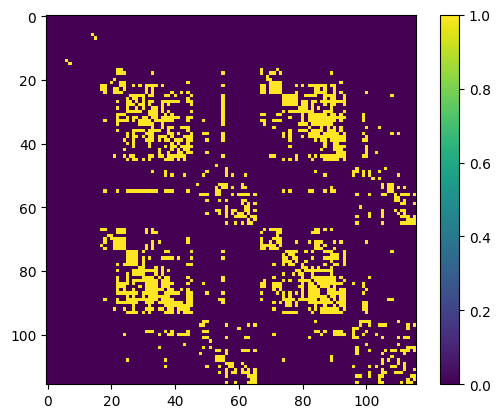

In [3]:
matrix = np.loadtxt('Cyril\prunned_matrix.txt')
matrix = matrix - np.eye(len(matrix),len(matrix))
plt.imshow(matrix)
plt.colorbar()
plt.show()

In [4]:
density = np.sum(matrix)/(len(matrix)**2)
print(f'The density of the pruned matrix is {density:.2f}')

The density of the pruned matrix is 0.11


In [7]:
%time complete_f_generator('Cyril\prunned_matrix.txt', 3)

[frozenset({0}), frozenset({1}), frozenset({2}), frozenset({3}), frozenset({4}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8}), frozenset({9}), frozenset({10}), frozenset({11}), frozenset({12}), frozenset({13}), frozenset({14}), frozenset({15}), frozenset({16}), frozenset({17}), frozenset({18}), frozenset({19}), frozenset({20}), frozenset({21}), frozenset({22}), frozenset({23}), frozenset({24}), frozenset({25}), frozenset({26}), frozenset({27}), frozenset({28}), frozenset({29}), frozenset({30}), frozenset({31}), frozenset({32}), frozenset({33}), frozenset({34}), frozenset({35}), frozenset({36}), frozenset({37}), frozenset({38}), frozenset({39}), frozenset({40}), frozenset({41}), frozenset({42}), frozenset({43}), frozenset({44}), frozenset({45}), frozenset({46}), frozenset({47}), frozenset({48}), frozenset({49}), frozenset({50}), frozenset({51}), frozenset({52}), frozenset({53}), frozenset({54}), frozenset({55}), frozenset({56}), frozenset({57}), frozenset({58}), frozen

KeyboardInterrupt: 

In [6]:
def complete_f_generator(file, max_dim):
    # Import datafile as matrix
    matrix = np.loadtxt(file)

    # Extract patient ID from filename
    identification_code = 'no HCA found'
    parts = file.split('_')
    for part in parts:
        if part.startswith("HCA"):
            identification_code = part[3:]
            break

    # Generate connection matrix and inverse
    clique_complex =  build_clique_complex(matrix, max_dim)
    print(clique_complex)
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = [0.5] #One temperature for now, to look at a range use here: np.arange(0, 1, 1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 1000, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)

    return [identification_code, max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]

In [10]:
# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['identification_code', 'max_entropy', 'min_energy', 'F_per_T', 'p_per_T', 'temperatures'])
max_clique_size = 3

for file in path[:4]:
    F = complete_f_generator(file, 3)
    # Append the list as a new row to the DataFrame
    df.loc[len(df)] = F

In [11]:
df

,identification_code,max_entropy,min_energy,F_per_T,p_per_T,temperatures


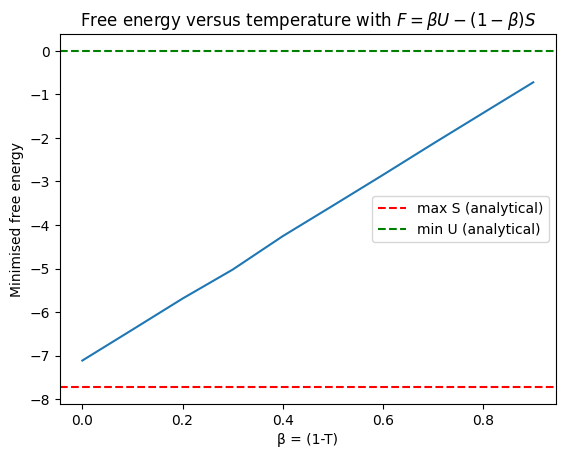

In [288]:
plt.plot(F[5], F[3])
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-F[1], color='r', linestyle='--', label='max S (analytical)')
plt.axhline(y=F[2], color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

# Pre-process the data to prepare as input for Pierre's code

**First explore the synchronous static case**

In [235]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [236]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    hist, bin_edges = np.histogram(data, bins=16)
    bin_numbers = np.digitize(data, bin_edges[:-1])
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [237]:
discretized_time_series

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,8,7,8,4,6,5,8,8,12,11,...,7,7,5,5,8,12,8,5,2,3
1,7,9,7,10,7,6,10,11,12,12,...,5,6,6,5,11,11,7,6,5,5
2,7,6,8,7,8,6,8,10,11,12,...,7,7,4,6,8,13,8,10,4,3
3,9,9,7,7,9,8,9,10,11,11,...,7,7,6,6,7,11,8,7,4,4
4,7,4,4,1,7,4,7,7,11,12,...,5,6,7,7,12,7,6,6,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,5,4,2,2,6,6,6,7,11,11,...,6,7,6,5,5,8,6,8,8,3
112,9,7,3,1,4,5,6,7,11,10,...,7,8,8,5,5,11,11,8,7,5
113,12,8,3,6,6,7,8,6,7,7,...,4,4,3,3,8,13,13,9,13,9
114,8,5,6,4,7,5,5,9,12,9,...,7,3,2,4,7,7,9,8,5,4


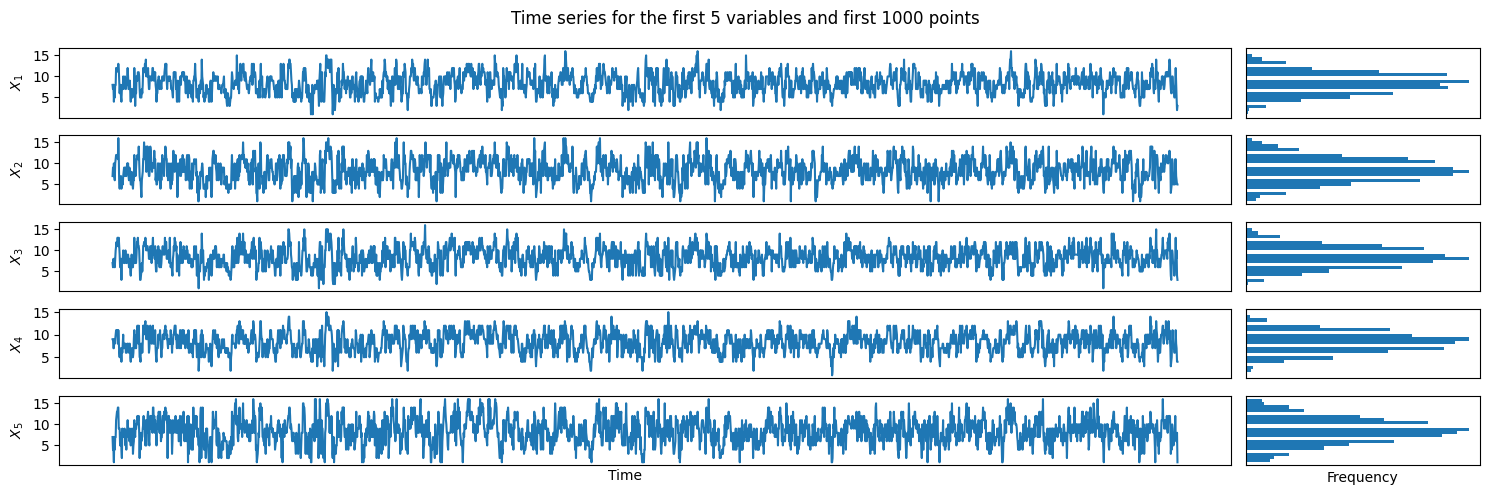

In [238]:
# Example DataFrame creation for demonstration
df = discretized_time_series.T

# Determine the number of subplots to create
num_subplots = min(len(df.columns), 5)

# Plotting
fig, axes = plt.subplots(nrows=num_subplots, ncols=2, figsize=(15, 5), 
                         gridspec_kw={'width_ratios': [5, 1]})  # Adjust width ratios

# Plot each variable on its subplot and histogram next to it
for i, col in enumerate(df.columns[:num_subplots]):  # Limit to num_subplots
    # Plot time series
    axes[i, 0].plot(df.index, df[col])
    axes[i, 0].set_ylabel(f'$X_{col+1}$')
    axes[i, 0].set_xticks([])  # Remove x-axis ticks
    
    # Plot histogram
    axes[i, 1].hist(df[col], bins=20, orientation='horizontal')
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Adjust layout
plt.suptitle('Time series for the first 5 variables and first 1000 points')
plt.xlabel('Frequency')
fig.text(0.42, 0.04, 'Time', ha='center')
plt.tight_layout()

# Display plot
plt.show()

In [188]:
np.savetxt('discretized_time_series.txt',discretized_time_series.T)

In [189]:
discretized_time_series = pd.read_csv('discretized_time_series.txt', sep=' ', header=None)

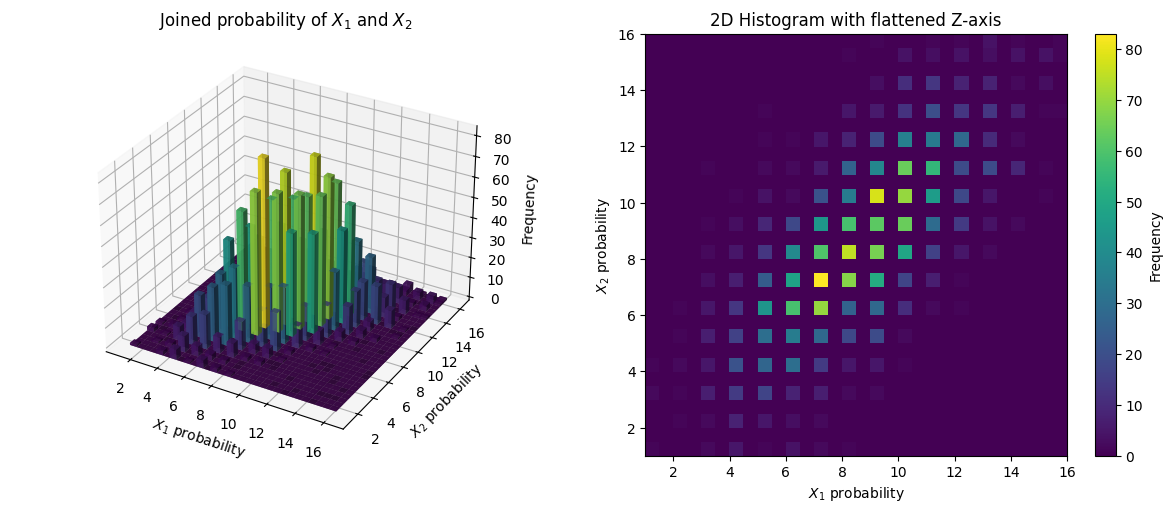

In [190]:
# Example for two correlations
x = discretized_time_series.iloc[:, 0].tolist()
y = discretized_time_series.iloc[:, 1].tolist()

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 3D histogram
ax1 = fig.add_subplot(121, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=plt.cm.viridis(dz / dz.max()), alpha=0.8)
ax1.set_xlabel('$X_1$ probability')
ax1.set_ylabel('$X_2$ probability')
ax1.set_zlabel('Frequency')
ax1.set_title('Joined probability of $X_1$ and $X_2$')

# Plot 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
img = ax[1].imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
ax[1].set_xlabel('$X_1$ probability')
ax[1].set_ylabel('$X_2$ probability')
ax[1].set_title('2D Histogram with flattened Z-axis')

# Figure specs
plt.colorbar(img, ax=ax[1], label='Frequency')
ax[0].axis('off')
plt.tight_layout()
plt.show()

**Redo this for fixed bin_edges**

In [285]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

OR Discretize in bins with fixed edges per variable

In [ ]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()

    max_BOLD = max(data)
    min_BOLD = min(data)
    desired_number_of_bins = 16
    stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
    bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

    bin_numbers = np.digitize(data, bin_edges)
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

Discretize in bins with fixed edges for the whole dataset

In [286]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()
max_BOLD = df.max().max()
min_BOLD = df.min().min()
desired_number_of_bins = 16
stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    bin_numbers = np.digitize(data, bin_edges)
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

OR Discretize in bins with fixed edges for the whole dataset use quantile to avoid extremes

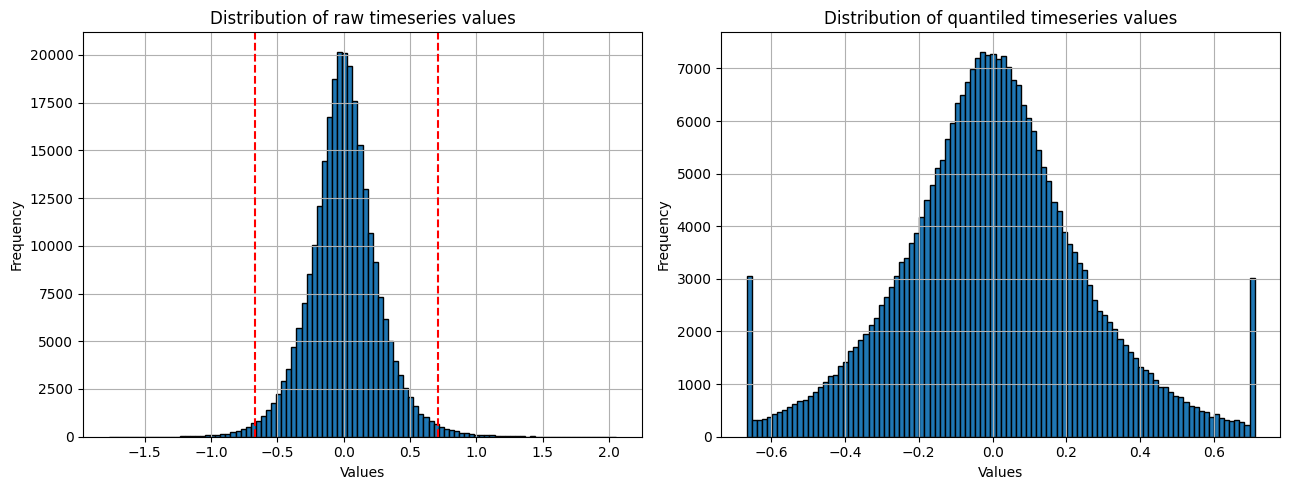

In [303]:
# Example DataFrame
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

# Stack the DataFrame into a Series
stacked_series = df.stack()

# Calculate the 99th percentile
quantile_99 = stacked_series.quantile(0.99)
quantile_01 = stacked_series.quantile(0.01)

df[df > quantile_99] = quantile_99
df[df < quantile_01] = quantile_01

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Plot the first histogram
axs[0].hist(stacked_series, bins=100, edgecolor='black')
axs[0].axvline(x=quantile_99, color='r', linestyle='--', label='99th quantile')
axs[0].axvline(x=quantile_01, color='r', linestyle='--', label='1th quantile')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of raw timeseries values')
axs[0].grid(True)

# Plot the second histogram
axs[1].hist(df.stack(), bins=100, edgecolor='black')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of quantiled timeseries values')
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [304]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()
max_BOLD = df.max().max()
min_BOLD = df.min().min()
desired_number_of_bins = 16
stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    bin_numbers = np.digitize(data, bin_edges)
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

Plot the process for the first 5 variables

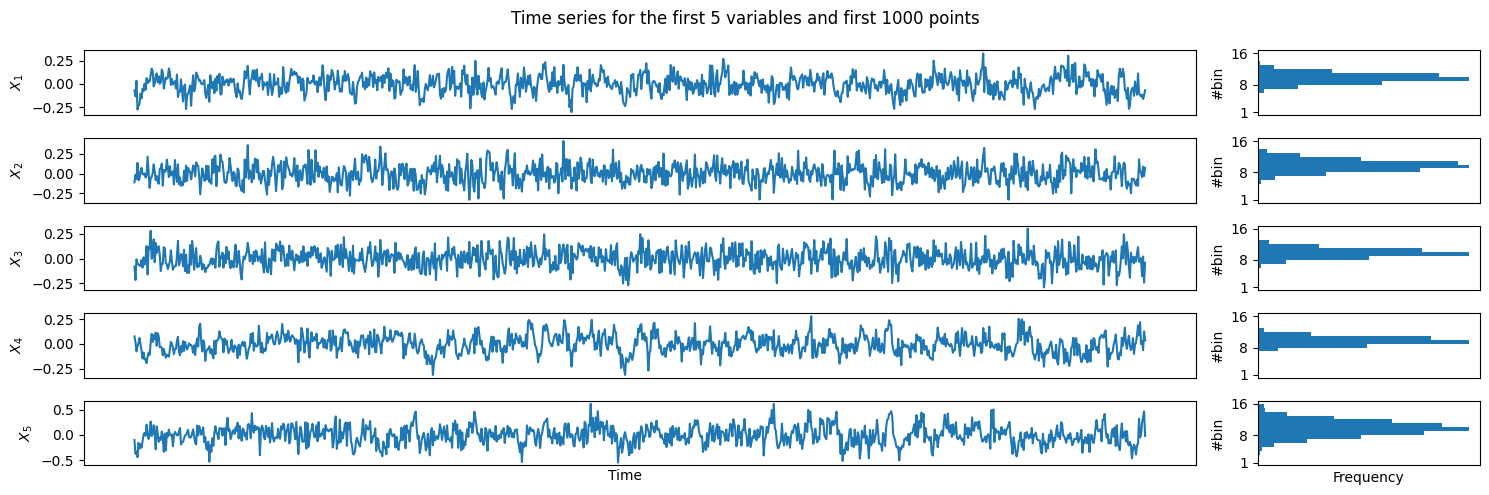

In [305]:
# Example DataFrame creation for demonstration
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)
df = df.T
df = df[:1000]

# Determine the number of subplots to create
num_subplots = 5

# Plotting
fig, axes = plt.subplots(nrows=num_subplots, ncols=2, figsize=(15, 5), 
                         gridspec_kw={'width_ratios': [5, 1]})  # Adjust width ratios

# Plot each variable on its subplot and histogram next to it
for i, col in enumerate(df.columns[:num_subplots]):  # Limit to num_subplots
    # Plot time series
    axes[i, 0].plot(df.index, df[col])
    axes[i, 0].set_ylabel(f'$X_{col+1}$')
    axes[i, 0].set_xticks([])  # Remove x-axis ticks
    
    # Plot histogram
    axes[i, 1].hist(discretized_time_series.T[col], bins=np.arange(0, 16, 1), orientation='horizontal')
    #axes[i, 1].hist(discretized_time_series.T[col], orientation='horizontal')
    axes[i, 1].set_ylabel('#bin')
    axes[i, 1].set_yticks([0,7,15])
    axes[i, 1].set_yticklabels(['1','8','16'])
    axes[i, 1].set_xticks([])
    #axes[i, 1].set_yticks([])

# Adjust layout
plt.suptitle('Time series for the first 5 variables and first 1000 points')
plt.xlabel('Frequency')
fig.text(0.42, 0.04, 'Time', ha='center')
plt.tight_layout()

# Display plot
plt.show()

In [306]:
np.savetxt('discretized_time_series.txt',discretized_time_series.T)

In [307]:
discretized_time_series = pd.read_csv('discretized_time_series.txt', sep=' ', header=None)

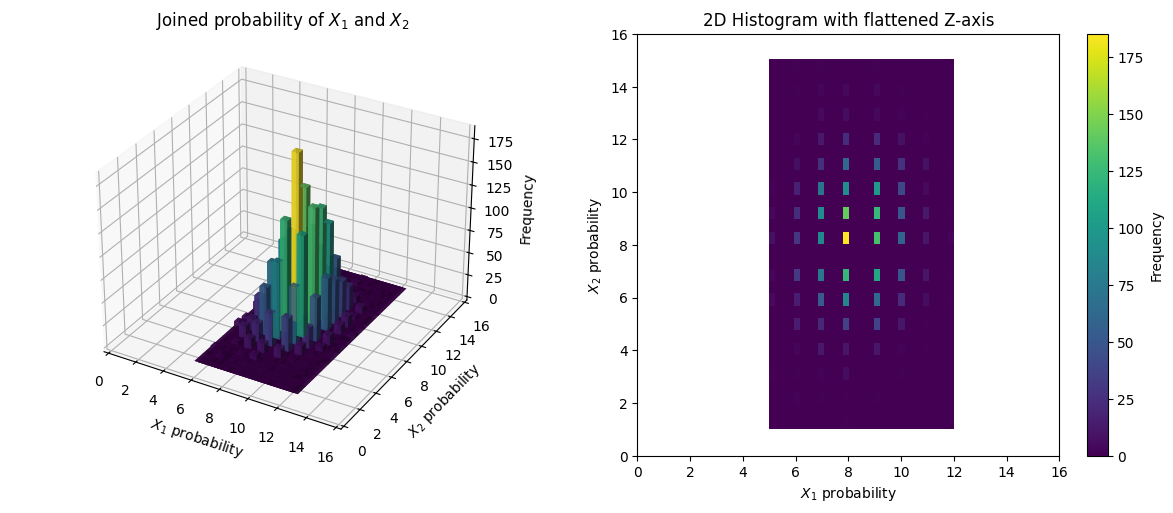

In [313]:
# Example for two correlations
x = discretized_time_series.iloc[:, 0].tolist()
y = discretized_time_series.iloc[:, 4].tolist()

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 3D histogram
ax1 = fig.add_subplot(121, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=plt.cm.viridis(dz / dz.max()), alpha=0.8)
ax1.set_xlabel('$X_1$ probability')
ax1.set_ylabel('$X_2$ probability')
ax1.set_zlabel('Frequency')
ax1.set_title('Joined probability of $X_1$ and $X_2$')
ax1.set_xlim(0, 16)
ax1.set_ylim(0, 16)

# Plot 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
img = ax[1].imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
ax[1].set_xlabel('$X_1$ probability')
ax[1].set_ylabel('$X_2$ probability')
ax[1].set_title('2D Histogram with flattened Z-axis')
ax[1].set_xlim(0, 16)
ax[1].set_ylim(0, 16)

# Figure specs
plt.colorbar(img, ax=ax[1], label='Frequency')
ax[0].axis('off')
plt.tight_layout()
plt.show()


**Implement moving window to explore the time dynamics**

In [322]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image  # Import Image module from Pillow

# Example data
data1 = df.iloc[0].tolist()[:1000]
data2 = df.iloc[1].tolist()[:1000]
window_size = 100
frames = []

# Convert data1 and data2 to NumPy arrays
data1 = np.array(data1)
data2 = np.array(data2)

# Calculate the 99th and 1st percentile of the total data
total_data = np.concatenate([data1, data2])
quantile_99 = np.percentile(total_data, 99)
quantile_01 = np.percentile(total_data, 1)

# Set the extremes to the quantile threshold for both datasets
data1[data1 > quantile_99] = quantile_99
data1[data1 < quantile_01] = quantile_01

data2[data2 > quantile_99] = quantile_99
data2[data2 < quantile_01] = quantile_01

for base in np.arange(0, len(data1) - window_size - window_size, 10):
    front_limit1 = base
    back_limit1 = base+window_size
    front_limit2 = base+window_size
    back_limit2 = base+window_size+window_size
    # Perform random walk
    walk1 = data1[front_limit1:back_limit1]
    walk2 = data2[front_limit2:back_limit2]

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [5, 1]})

    # Plot time series 1
    axs[0, 0].plot(range(len(data1)), data1)
    axs[0, 0].axvline(x=front_limit1, color='red', linestyle='--')
    axs[0, 0].axvline(x=back_limit1, color='red', linestyle='--')
    axs[0, 0].fill_between(range(front_limit1, back_limit1), min(data1), max(data1), color='salmon', alpha=0.3)
    axs[0, 0].set_ylabel('$X_1$')

    # Plot histogram 1
    hist1, bin_edges1 = np.histogram(walk1, bins=16)
    axs[0, 1].hist(walk1, bins=16, color='salmon', edgecolor='black', orientation='horizontal')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_ylim(quantile_01, quantile_99)
    axs[0, 1].set_yticks([quantile_01, 0, quantile_99])
    axs[0, 1].set_yticklabels(['1', '8', '16'])
    axs[0, 1].set_ylabel('#bin')
    #axs[0, 1].set_yticks([])

    # Plot time series 2
    axs[1, 0].plot(range(len(data2)), data2)
    axs[1, 0].axvline(x=front_limit2, color='red', linestyle='--')
    axs[1, 0].axvline(x=back_limit2, color='red', linestyle='--')
    axs[1, 0].fill_between(range(front_limit2, back_limit2), min(data2), max(data2), color='salmon', alpha=0.3)
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('$X_2$')

    # Plot histogram 2
    hist2, bin_edges2 = np.histogram(walk2, bins=16)
    axs[1, 1].hist(walk2, bins=16, color='salmon', edgecolor='black', orientation='horizontal')
    axs[1, 1].set_xlabel('Frequency')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_ylim(quantile_01, quantile_99)
    axs[1, 1].set_yticks([quantile_01, 0, quantile_99])
    axs[1, 1].set_yticklabels(['1', '8', '16'])
    axs[1, 1].set_ylabel('#bin')
    #axs[1, 1].set_yticks([])

    # Adjust layout
    plt.tight_layout()

    # Convert figure to PIL Image
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Append the current frame to the list of frames
    frames.append(img)

    # Close the figure to avoid memory leaks
    plt.close(fig)

# Save frames as GIF
frames[0].save('combined_timeseries_sliding_2.gif', save_all=True, append_images=frames[1:], optimize=False, duration=200, loop=0)

**Generate time-slided list for input Pierre's code**

Using discretizing for fixed bin edges using the whole dataset with quantile

In [3]:
# Example DataFrame
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

# Stack the DataFrame into a Series
stacked_series = df.stack()

# Calculate the 99th percentile
quantile_99 = stacked_series.quantile(0.99)
quantile_01 = stacked_series.quantile(0.01)

df[df > quantile_99] = quantile_99
df[df < quantile_01] = quantile_01

# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()
max_BOLD = df.max().max()
min_BOLD = df.min().min()
desired_number_of_bins = 16
stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    bin_numbers = np.digitize(data, bin_edges)
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [4]:
discretized_time_series

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,7,7,9,5,5,6,7,6,8,7,...,8,8,7,8,8,9,8,6,6,7
1,7,8,7,10,7,8,9,9,8,8,...,6,7,9,7,10,8,7,7,8,9
2,7,6,8,8,8,7,7,8,7,8,...,9,8,6,8,8,10,8,9,8,7
3,9,8,7,8,8,9,8,7,7,7,...,8,8,9,8,8,8,7,7,7,8
4,7,4,4,3,6,5,6,5,7,8,...,6,8,10,9,11,6,6,6,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,5,4,3,3,6,7,5,5,7,7,...,7,9,9,7,7,6,6,8,10,8
112,9,7,4,3,4,6,5,5,7,6,...,9,10,10,7,7,8,9,8,9,9
113,12,8,4,7,6,9,7,4,4,3,...,5,5,6,5,8,9,11,9,13,12
114,8,5,7,5,7,6,4,7,8,5,...,9,4,4,6,8,6,8,8,8,8


In [5]:
%run infotopo.py

In [6]:
dataset = np.array(discretized_time_series).T
print(dataset.shape)

(2400, 116)


In [10]:
def obtain_mutual_information(dataset, max_d, number_of_variables):  
    # Settings
    work_on_transpose = False
    nb_of_values = 16
    deformed_probability_mode = False
    supervised_mode = False
    forward_computation_mode = True
    sampling_mode = 1

    # Call infotopo function
    information_topo = infotopo(dimension_max = max_d, 
                                dimension_tot = number_of_variables, 
                                sample_size = 2400, 
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values, 
                                sampling_mode = sampling_mode, 
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode, 
                                forward_computation_mode = forward_computation_mode)

    Nentropie = information_topo.simplicial_entropies_decomposition(dataset) 
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)

    return Nentropie, Ninfomut, Nfree_energy

In [13]:
%time Nentropie, Ninfomut, Nfree_energy = obtain_mutual_information(dataset, 4, 10)

2024-03-31 12:50:51,017 : INFO : PROGRESS: at percent #0
2024-03-31 12:50:51,028 : INFO : PROGRESS: at percent #1
2024-03-31 12:50:51,028 : INFO : PROGRESS: at percent #2
2024-03-31 12:50:51,044 : INFO : PROGRESS: at percent #3
2024-03-31 12:50:51,060 : INFO : PROGRESS: at percent #3
2024-03-31 12:50:51,075 : INFO : PROGRESS: at percent #4
2024-03-31 12:50:51,088 : INFO : PROGRESS: at percent #5
2024-03-31 12:50:51,102 : INFO : PROGRESS: at percent #6
2024-03-31 12:50:51,112 : INFO : PROGRESS: at percent #7
2024-03-31 12:50:51,112 : INFO : PROGRESS: at percent #7
2024-03-31 12:50:51,129 : INFO : PROGRESS: at percent #8
2024-03-31 12:50:51,129 : INFO : PROGRESS: at percent #9
2024-03-31 12:50:51,146 : INFO : PROGRESS: at percent #10
2024-03-31 12:50:51,157 : INFO : PROGRESS: at percent #10
2024-03-31 12:50:51,162 : INFO : PROGRESS: at percent #11
2024-03-31 12:50:51,173 : INFO : PROGRESS: at percent #12
2024-03-31 12:50:51,179 : INFO : PROGRESS: at percent #13
2024-03-31 12:50:51,189 : 

Percent of tuples processed : 0


2024-03-31 12:50:51,210 : INFO : PROGRESS: at percent #15
2024-03-31 12:50:51,228 : INFO : PROGRESS: at percent #16
2024-03-31 12:50:51,237 : INFO : PROGRESS: at percent #17
2024-03-31 12:50:51,248 : INFO : PROGRESS: at percent #17
2024-03-31 12:50:51,262 : INFO : PROGRESS: at percent #18
2024-03-31 12:50:51,262 : INFO : PROGRESS: at percent #19
2024-03-31 12:50:51,280 : INFO : PROGRESS: at percent #20
2024-03-31 12:50:51,295 : INFO : PROGRESS: at percent #21
2024-03-31 12:50:51,312 : INFO : PROGRESS: at percent #21
2024-03-31 12:50:51,322 : INFO : PROGRESS: at percent #22
2024-03-31 12:50:51,328 : INFO : PROGRESS: at percent #23
2024-03-31 12:50:51,348 : INFO : PROGRESS: at percent #24
2024-03-31 12:50:51,362 : INFO : PROGRESS: at percent #24
2024-03-31 12:50:51,378 : INFO : PROGRESS: at percent #25
2024-03-31 12:50:51,393 : INFO : PROGRESS: at percent #26
2024-03-31 12:50:51,399 : INFO : PROGRESS: at percent #27
2024-03-31 12:50:51,412 : INFO : PROGRESS: at percent #28
2024-03-31 12:

CPU times: total: 328 ms
Wall time: 2 s


In [15]:
print(Nentropie)

{(1,): 2.3158932632922564, (2,): 2.6034634969390407, (3,): 2.2046295200496218, (4,): 2.1044846023411123, (5,): 3.0029452453336924, (6,): 2.638108973868445, (7,): 2.3989199097781473, (8,): 2.615714896072481, (9,): 2.263040738115215, (10,): 2.6811687257127006, (1, 2): 4.8805421585818465, (1, 3): 4.488440447975575, (1, 4): 4.401668698021726, (1, 5): 5.292947649422972, (1, 6): 4.928712198944475, (1, 7): 4.69343149204747, (1, 8): 4.910914092085232, (1, 9): 4.461395966564169, (1, 10): 4.956700547851962, (2, 3): 4.7843964424389975, (2, 4): 4.68200561319157, (2, 5): 5.5718712811913385, (2, 6): 5.214982538578653, (2, 7): 4.977805075017443, (2, 8): 5.191782724437431, (2, 9): 4.836585157039239, (2, 10): 5.227195078224136, (3, 4): 4.274572233659144, (3, 5): 5.178206181799959, (3, 6): 4.8240403622608, (3, 7): 4.578618979337396, (3, 8): 4.783080523118425, (3, 9): 4.4472156288857905, (3, 10): 4.862376669622574, (4, 5): 5.063441717078924, (4, 6): 4.7151227893583245, (4, 7): 4.412188415811955, (4, 8): 

In [62]:
average_free_energy = sum(Nfree_energy.values())/len(Nfree_energy.values())
print(average_free_energy)

average_free_energy_component = sum(Ninfomut.values())/len(Ninfomut.values())
print(average_free_energy_component)

0.1462078903540543
0.09236833721938942


In [41]:
print(len(Nentropie))
print(len(Ninfomut))

20875
20875


In [44]:
# Define the dictionary
dictionary = Ninfomut
nb_values = 50

# Extract keys and values
keys = list(dictionary.keys())
values = list(dictionary.values())

# Print the lists of keys and values
print("Length of list of Keys:", len(keys))
#print("List of Values:", values)

# Print the number of combinations
print("Number of combinations:", math.comb(nb_values, 3)+math.comb(nb_values, 2)+math.comb(nb_values, 1))

Length of list of Keys: 20875
Number of combinations: 20875


In [99]:
# Example dictionaries
dict1 = {(1,):0.245, (2,):0.456, (1, 2): 0.123}
dict2 = {(2,):0.767, (3,):0.178, (2, 3): 0.367}
dict3 = {(1,):0.267, (4,):0.278, (6,): 0.128, (1, 4, 6):0.236}
dict_list = [dict1, dict2, dict3]

In [100]:
def count_occurrences(dicts):
    occurrences = {}
    # Iterate over all dictionaries
    for d in dicts:
        for key in d:
            occurrences[key] = occurrences.get(key, 0) + 1
    return occurrences

def generate_clique_probabilities(dict_list):  
      
    # Count occurrences
    occurrences = count_occurrences(dict_list)

    # Divide each value by the sum
    normalized_occurrences = {key: value /sum(occurrences.values()) for key, value in occurrences.items()}
    
    dict_values_list = []

    for i in range(0, len(dict_list)):
        # Initialize an empty list to store values
        values_list = []

        # Iterate over keys of dict1
        for key in dict_list[i]:
            # Check if the key exists in normalized_occurrences
            if key in normalized_occurrences:
                # If the key exists, append its corresponding value to the list
                values_list.append(normalized_occurrences[key])

        dict_values_list.append(np.array(values_list))

    return dict_values_list

In [101]:
F_list = []
clique_probabilities_list = generate_clique_probabilities(dict_list)

for i in range(0, len(dict_list)):
    clique_complex = [frozenset(key) for key in dict_list[i] if key in normalized_occurrences]
    probability = clique_probabilities_list[i]
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)
    F = energy_function(probability, inverse_connectivity_matrix)
    F_list.append(F)

print(F_list)

[-0.010000000000000002, 0.010000000000000002, 0.015000000000000003]
